In [1]:
import json
import sys
from os import path
config_params = json.load(open('config.json','r'))['lisi1']
print(json.dumps(config_params, indent=4, sort_keys=True))
home_path = config_params["home_path"]
eval_home = config_params["eval_home"]
cooc_home = config_params["cooc_home"]
sys.path.append(path.abspath("../"))
sys.path.append(path.abspath("../bioasqdataset"))
import bioasqdataset.common.qa_data as qa_data
import bioasqdataset.common.bioasq_util as bioasq_util
word2vec_model = config_params["word2vec_model"]
sys.path.insert(0, eval_home)
sys.path.insert(0, home_path+'/common')
import map_callback
import map_eval
import bioasq_eval
from operator import itemgetter 
import importlib
import threading
from os import listdir
from os.path import isfile, join
import matplotlib
import seaborn as sns
import pylab as plt
import nlp_util
import time
import os
import pandas as pd
import json
import logging
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.layers import Lambda, Conv2D, Conv3D, MaxPooling2D, GlobalMaxPool2D, GlobalMaxPool3D, MaxPool2D, MaxPool3D, Flatten, Dense, Dropout, Input, Concatenate, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
from tqdm import tqdm
import p_tqdm
from itertools import groupby
import sys
import pickle
import numpy as np
import threading
from scipy import spatial
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from random import shuffle
import random
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
#tensorflow.keras.backend.set_image_data_format('channels_first')
print(tf.keras.backend.image_data_format())
import importlib
importlib.reload(nlp_util)

logging.config.fileConfig(home_path+"/logging.conf")
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

max_terms = 40
sim_dim = 1
working_folder = 'working_folder'
model_id = 'cnn_sim_dml'
positive_rate = 0.5
prep_step = []

{
    "bioasq_data": "/home/aerossom/bioasq_data/",
    "cooc_home": "/home/aerossom/bioasq_data/embeddings/cooccurrence_matrices",
    "eval_home": "/home/aerossom/git_repos/Evaluation-Measures/",
    "home_path": "/home/aerossom/git_repos/dmlpr",
    "word2vec_model": "/home/aerossom/bioasq_data/embeddings/wikipedia-pubmed-and-PMC-w2v.bin"
}
channels_last


In [2]:
w2v = KeyedVectors.load_word2vec_format(word2vec_model, binary=True)

In [3]:
#load terms coocurrence matrix
#vocab_to_idx_text = pickle.load(open(cooc_home+'/term_vocab_to_idx_bin2.pkl','rb'))
#Xc_norm_text = pickle.load(open(cooc_home+'/term_co_occ_bin2.pkl','rb'))
#load coocurrence matrix
#vocab_to_idx_concept = pickle.load(open(cooc_home+'/concept_vocab_to_idx2.pkl','rb'))
#Xc_norm_concept = pickle.load(open(cooc_home+'/concept_co_occ.pkl','rb'))
vocab_to_idx_text = pickle.load(open(cooc_home+'/term_vocab_to_idx_bin2.pkl','rb'))
Xc_norm_text = pickle.load(open(cooc_home+'/term_co_occ_bin2.pkl','rb'))
#load coocurrence matrix
vocab_to_idx_concept = pickle.load(open(cooc_home+'/concept_vocab_to_idx_bin2.pkl','rb'))
Xc_norm_concept = pickle.load(open(cooc_home+'/concept_co_occ_bin2.pkl','rb'))

In [4]:
def getSalienceScore(qv, av, maxterms=40):
    score = 0
    imp_postag = set(['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'NN', 'NNS', 'NNP', 'NNPS', 'JJ'])
    #imp_postag = set(['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP', 'WRB', 'NN', 'NNS', 'NNP', 'NNPS', 'MD'])
    #imp_postag = set(['WRB','VB', 'VBD', 'VBG', 'VBN', 'VBP','VBZ', 'WDT', 'WP', 'WRB', 'NN', 'NNS', 'NNP', 'NNPS', 'MD'])
    pq = nltk.pos_tag(qv)
    pa = nltk.pos_tag(av)
    out_m = np.zeros( (maxterms, maxterms) )
    if len(pq)>maxterms:
        pq = pq[0:maxterms]
    if len(pa)>maxterms:
        pa = pa[0:maxterms]
    wq_m = np.zeros((maxterms,maxterms))
    wa_m = np.zeros((maxterms,maxterms))

    pq_l = [len(set([qt[1]]).intersection(imp_postag))+1 for qt in pq]
    pa_l = [len(set([at[1]]).intersection(imp_postag))+1 for at in pa]

    wq_m[0:len(pa_l) , 0:len(pq_l)]=pq_l
    wa_m[0:len(pq_l) , 0:len(pa_l)]=pa_l

    out_m = (wq_m.T + wa_m)/4
    return out_m[0:maxterms,0:maxterms]

def buildCosineSimMatrix(questions_answer_pairs, max_terms=max_terms):
    #Construct Question Answer Matrix Pairs
    x = []
    y = []    
    data = p_tqdm.p_map(transform_single_pair,questions_answer_pairs)
    x, y = zip(*data)
    return np.array(x), np.array(y)

def transform_single_pair(pair, measurements=['cossin'], max_terms=max_terms):
    #Construct Question Answer Matrix Pairs
    q_list = nlp_util.data_preprocess(pair['body'], prep_step)
    #Answer processing
    a_list = nlp_util.data_preprocess(pair['text'], prep_step)
    #Get salience score
    sal_matrix = getSalienceScore(q_list, a_list)
    #similarity matrices
    cos_matrix = np.zeros((max_terms,max_terms))
    co_occ_matrix_term = np.zeros((max_terms,max_terms))
    co_occ_matrix_concept = np.zeros((max_terms,max_terms))
    sim_tensor = None
    if (len(q_list) > 1) & (len(a_list) > 1):
        for i in range(min(max_terms, len(q_list))):
            q_v = None
            q_term_idx = None
            
            if q_list[i] in w2v:
                q_v = w2v[q_list[i]]
                
            if q_list[i] in vocab_to_idx_text:
                q_term_idx = vocab_to_idx_text[q_list[i]]

            q_concept_idx = None
            if q_list[i] in vocab_to_idx_concept:
                q_concept_idx = vocab_to_idx_concept[q_list[i]]
            for j in range(min(max_terms, len(a_list))):
                #Cosine Similarity
                if (a_list[j] in w2v) & (q_v is not None):
                    a_v = w2v[a_list[j]]
                    distance = spatial.distance.cosine(q_v, a_v)
                    similarity = 1 - distance/2
                    cos_matrix[i,j] = similarity
                #Term co-occurrence Similarity
                if (a_list[j] in vocab_to_idx_text) & (q_term_idx is not None):
                    a_term_idx = vocab_to_idx_text[a_list[j]]
                    co_occ_matrix_term[i,j] = Xc_norm_text[q_term_idx, a_term_idx]

                #concept co-occurrence Similarity
                if (a_list[j] in vocab_to_idx_concept) & (q_concept_idx is not None):
                    a_concept_idx = vocab_to_idx_concept[a_list[j]]
                    co_occ_matrix_concept[i,j] = Xc_norm_concept[q_concept_idx, a_concept_idx]
                    
    #cosine sim with weight
    cos_matrix = np.multiply(cos_matrix,sal_matrix)
    #sim_tensor = np.expand_dims(cos_matrix, axis=-1)
    #sim_tensor = np.stack([cos_matrix, co_occ_matrix_term, co_occ_matrix_concept], axis=-1)
    sim_tensor = np.expand_dims(cos_matrix, axis=-1)
    if np.isnan(sim_tensor).any():
        print('ERROR IS NAN: ',pair)
    else:
        return (sim_tensor, pair['label'])

In [5]:
EMBEDDING_SIZE = 128
MARGIN = 0.4

def pos_distance(y_true, y_pred):
    positive_vec = y_pred[:, 0]
    pos_dist = K.sum(positive_vec, axis=-1 )
    return pos_dist

def neg_distance(y_true, y_pred):
    negative_vec = y_pred[:, 1]
    neg_dist = K.sum(negative_vec, axis=-1 )
    return neg_dist

def triplet_loss_distance(y_true, y_pred, alpha = MARGIN):
    positive_vec = y_pred[:, 0]
    negative_vec = y_pred[:, 1]
    
    # distance between the anchor and the positive
    pos_sum = K.sum( (positive_vec), axis=-1 )
    neg_sum = K.sum( (negative_vec), axis=-1 )
    
    basic_loss = positive_vec - negative_vec + alpha
    
    loss = K.maximum(basic_loss,0.0) 

    return loss

In [6]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K


sim_model = None
train_model = None

def make_sim_model(layer_name='sim_model'):
    model = Sequential(name=layer_name)
    model.add(Conv2D(512, (3, 3), padding='same',
                 input_shape=(max_terms, max_terms, sim_dim)))
    model.add(Activation('relu'))
    model.add(GlobalMaxPool2D(name='cnn_max_pool'))
    model.add(Dropout(0.1))
    model.add(Dense(256, name='dense_1st'))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.1))
    model.add(Dense(128, name='emdedding_128d'))
    model.add(Activation('relu'))
    model.add(Dense(1, name='output'))
    model.add(Activation('sigmoid'))
    return model

def make_siamese_model(sim_model):
    positive = Input(shape=(max_terms, max_terms, sim_dim))
    negative = Input(shape=(max_terms, max_terms, sim_dim))
    positive_out = sim_model(positive)
    negative_out = sim_model(negative)
    vecs = Concatenate(axis=1, name='vectors')([positive_out, negative_out])
    model = Model([positive, negative], vecs)
    #model.compile('adam', triplet_loss_cosine, metrics=[cos_sim_pos, cos_sim_neg])
    model.compile('adam', triplet_loss_distance, metrics=[pos_distance, neg_distance])
    return model

sim_model = make_sim_model()
train_model = make_siamese_model(sim_model)
sim_model.summary()
train_model.summary()

Model: "sim_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 40, 512)       5120      
_________________________________________________________________
activation (Activation)      (None, 40, 40, 512)       0         
_________________________________________________________________
cnn_max_pool (GlobalMaxPooli (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1st (Dense)            (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0 

In [7]:
importlib.reload(qa_data)

<module 'bioasqdataset.common.qa_data' from '/home/aerossom/git_repos/bioasqdataset/common/qa_data.py'>

In [8]:
#load dataset

#dataset_id = ('BiosqDataSet', config_params["train_data_dir"])
dataset_id = ('BioasqUnalDataSet', '../bioasqdataset/generated_pairs') 
ds = qa_data.DataSetFactory.loadDataSet(dataset_id[0],year='2016',\
                            path=dataset_id[1], threshold=(0.0,1))
bioasq_dataset = ds.build_qa_pairs(ds)

pairs = []

for p in bioasq_dataset:
    pairs.append( { 'id': p.qi,  'body': p.q, 'text': p.a, 'label':p.l, 'params':p.params } )

2016 ../bioasqdataset/generated_pairs
Loaded BioasqUnalDataSet
threshold  (0.0, 1)
Number of pairs: 500248


In [9]:
bioasq_dataset[5].values()

"qi: 530cf4fe960c95ad0c000009, q: Can tetracycline affect tooth formation?, ai: 530cf4fe960c95ad0c000009-3855899-title-0-title-82, a: Dental caries and tetracycline-stained dentition in an American Indian population., l: 0, params: {'bioSentVecCosSim': 0.3717852830886841}"

In [10]:
pairs_tx = p_tqdm.p_map(transform_single_pair, pairs)

In [11]:
for i, pair in enumerate(pairs): 
    pair['representation'] = pairs_tx[i]

In [12]:
pairs[0]['representation'][0].shape

(40, 40, 1)

In [13]:
ids = list(set(map(itemgetter('id'), pairs)))
random.shuffle(ids)
qids_train, qids_val, qids_test = np.split( np.array(ids), [ int(.75 * len(ids)), int(.85 * len(ids)) ] )
qids_train = set(qids_train)
qids_val = set(qids_val)
qids_test = set(qids_test)
pairs_train = [ x for x in pairs if x['id'] in qids_train ]
pairs_val = [ x for x in pairs if x['id'] in qids_val ]
pairs_test = [ x for x in pairs if x['id'] in qids_test ]

In [14]:
ids = set([ p['id'] for p in pairs_train ])
samples_dict_pos = {}
samples_dict_neg = {}
for i, pair in enumerate(pairs_train):
    if pair['label'] == 1:
        if pair['id'] not in samples_dict_pos:
            samples_dict_pos[pair['id']] = [i]
        else:
            samples_dict_pos[pair['id']].append(i)
    if pair['label'] == 0:
        if pair['id'] not in samples_dict_neg:
            samples_dict_neg[pair['id']] = [i]
        else:
            samples_dict_neg[pair['id']].append(i)
            
ids = set(samples_dict_neg).intersection(samples_dict_pos)

In [15]:
import random

def data_generator(passages, batch_size = 32, threshold = None ):
    samples_dict_pos = {}
    samples_dict_neg = {}
    _passages = [ p for p in passages
                       if ( (p['params']['bioSentVecCosSim']>=threshold[0]) and
                              (p['params']['bioSentVecCosSim']<=threshold[1]) and 
                               p['label'] == 0 ) or ( p['label'] == 1 ) ]
    print('remaining passages in generator {}'.format(len(_passages)))
    for i, pair in enumerate(_passages):
        if pair['label'] == 1:
            if pair['id'] not in samples_dict_pos:
                samples_dict_pos[pair['id']] = [i]
            else:
                samples_dict_pos[pair['id']].append(i)
        if pair['label'] == 0:
            if pair['id'] not in samples_dict_neg:
                samples_dict_neg[pair['id']] = [i]
            else:
                samples_dict_neg[pair['id']].append(i)
    print('+({}), -({})'.format(len(samples_dict_pos), len(samples_dict_neg)))
    ids = list(set(samples_dict_neg).intersection(samples_dict_pos))
    print('# {}'.format(len(ids)))

    while True:
        X_batch_POS = np.empty((batch_size, max_terms, max_terms, sim_dim), dtype=np.float32)
        X_batch_NEG = np.empty((batch_size, max_terms, max_terms, sim_dim), dtype=np.float32)
        y = []

        for i in range(batch_size):
            id_idx = random.choice(ids)
            pos_sample_idx = random.choice(samples_dict_pos[id_idx])
            neg_sample_idx = random.choice(samples_dict_neg[id_idx])
            X_batch_POS[i] = passages[pos_sample_idx]['representation'][0]
            X_batch_NEG[i] = passages[neg_sample_idx]['representation'][0]
            y.append([0,1])

        yield ( [X_batch_POS, X_batch_NEG], np.array(y) )

In [16]:
importlib.reload(map_callback)

<module 'map_callback' from '/home/aerossom/git_repos/dmlpr/common/map_callback.py'>

In [17]:
from datetime import datetime
logdir = "logs/scalars/" #+ datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=2, write_grads=True)

In [30]:
# #############
# Call Backs
# #############
filepath = working_folder + "/" + model_id + "_weights.best.h5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
                                                verbose=1, save_best_only=True, mode='min')

earlyStop = tf.keras.callbacks.EarlyStopping(restore_best_weights=True,
                                              monitor='val_loss',
                                              min_delta=0, 
                                              patience=5,
                                              verbose=1, 
                                              mode='auto')

best_model_path = 'working_folder/map_best_' + model_id + '.h5'

"""
Return the list of predictions in binary format {1: for related passages, 0: no related}
"""
def predict_function(x_samples):
    x_samples = np.asarray([ x[0] for x in x_samples])
    y_pred = sim_model.predict( x_samples )
    y_pred = np.squeeze(y_pred)
    y_pred = list(np.where(y_pred > 0.5, 1, 0))
    return y_pred

mapcallback = map_callback.MAPCallback(pairs_val, filepath=best_model_path, 
                                       predict_fc=predict_function, save_weights_only=True)

batch_size = 32
epochs = 10
history = train_model.fit_generator(
    data_generator(pairs_train, batch_size=batch_size, threshold = (0.0, 1)), 
    validation_data=data_generator(pairs_val, batch_size=batch_size, threshold = (0.0, 1)),
    steps_per_epoch=500,#int(len(pairs_train)/batch_size), 
    validation_steps=50,#int(len(pairs_val)/batch_size),
    epochs=epochs,
    callbacks=[checkpoint, earlyStop, mapcallback, tensorboard_callback])

train_model.load_weights(filepath)

remaining passages in generator 379374
+(1995), -(2324)
# 1848
remaining passages in generator 49628
+(266), -(302)
# 239
Train for 500 steps, validate for 50 steps
Epoch 1/10
497/500 [============================>.] - ETA: 0s - loss: 0.1834 - pos_distance: 9.6886 - neg_distance: 20.7912
Epoch 00001: val_loss improved from inf to 0.13694, saving model to working_folder/cnn_sim_dml_weights.best.h5
groups # 321
validation map # 0.3760421994420996
validation mrr # 0.0
Epoch 00000:  MAP  improved from -inf to 0.37604, saving model to working_folder/map_best_cnn_sim_dml.h5
500/500 [==============================] - 19s 38ms/step - loss: 0.1832 - pos_distance: 9.6878 - neg_distance: 20.8074 - val_loss: 0.1369 - val_pos_distance: 8.9522 - val_neg_distance: 23.0394
Epoch 2/10
496/500 [============================>.] - ETA: 0s - loss: 0.1408 - pos_distance: 9.2683 - neg_distance: 22.9010
Epoch 00002: val_loss improved from 0.13694 to 0.13291, saving model to working_folder/cnn_sim_dml_weights.b

In [34]:
#get best map model
train_model.load_weights(best_model_path)

In [27]:
importlib.reload(map_eval)

<module 'map_eval' from '/home/aerossom/git_repos/dmlpr/common/map_eval.py'>

In [20]:
best_model_path

'working_folder/map_best_cnn_sim_dml.h5'

In [21]:
weights_sim_model = train_model.get_layer('sim_model').get_weights()
sim_model = make_sim_model() #assumed it returns the model of simmodel
sim_model.set_weights(weights_sim_model);

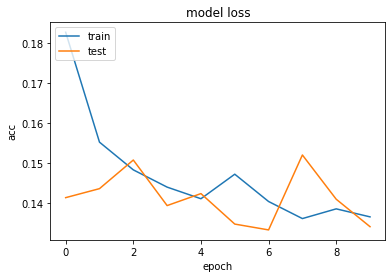

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

pd.DataFrame.from_dict(history.history).to_csv(working_folder+'/train_baseline.csv',index=False)

In [23]:
pair_id = 1
print(pairs_test[pair_id]['label'],
      sim_model.predict(np.expand_dims((pairs_test[pair_id]['representation'][0]), axis=0))[0][0]
     )

0 0.20577271


In [24]:
sim_model.layers

In [25]:
extractor = keras.Model(inputs=sim_model.inputs,
                        outputs=sim_model.layers[6].output)

In [26]:
test_emb = [ (extractor(np.array([pair['representation'][0]]))[0],
              pair['label'],
              pair['params']['bioSentVecCosSim']) for pair in pairs_test ]

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform([ x[0] for x in test_emb ])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 71413 samples in 5.637s...
[t-SNE] Computed neighbors for 71413 samples in 127.243s...
[t-SNE] Computed conditional probabilities for sample 1000 / 71413
[t-SNE] Computed conditional probabilities for sample 2000 / 71413
[t-SNE] Computed conditional probabilities for sample 3000 / 71413
[t-SNE] Computed conditional probabilities for sample 4000 / 71413
[t-SNE] Computed conditional probabilities for sample 5000 / 71413
[t-SNE] Computed conditional probabilities for sample 6000 / 71413
[t-SNE] Computed conditional probabilities for sample 7000 / 71413
[t-SNE] Computed conditional probabilities for sample 8000 / 71413
[t-SNE] Computed conditional probabilities for sample 9000 / 71413
[t-SNE] Computed conditional probabilities for sample 10000 / 71413
[t-SNE] Computed conditional probabilities for sample 11000 / 71413
[t-SNE] Computed conditional probabilities for sample 12000 / 71413
[t-SNE] Computed conditional probabilities for 

In [28]:
x = []
y = []
clazz = []
for i,p in enumerate(test_emb):
    if (p[1] == 0) and (p[2]<0.5):
        x.append(tsne_results[i][0])
        y.append(tsne_results[i][1])
        clazz.append('easy_negative')
    if (p[1] == 0) and (p[2]>0.4):
        x.append(tsne_results[i][0])
        y.append(tsne_results[i][1])
        clazz.append('hard_negative')
    if (p[1] == 1):
        x.append(tsne_results[i][0])
        y.append(tsne_results[i][1])
        clazz.append('answer')

tsne_df = pd.DataFrame({'X':x,
                        'Y':y,
                        'class':clazz})
tsne_df.head()

,X,Y,class
0,2.687100,-4.797256,easy_negative
1,2.687100,-4.797256,hard_negative
2,5.359701,-2.990144,easy_negative
3,5.359701,-2.990144,hard_negative
4,-3.213504,-5.914009,easy_negative


In [29]:
print(tsne_df['class'].value_counts())
tsne_df2 = tsne_df.groupby('class').apply(lambda x: x.sample(3116))
print(tsne_df2['class'].value_counts())

easy_negative    52446
hard_negative    27573
answer            4806
Name: class, dtype: int64
hard_negative    3116
easy_negative    3116
answer           3116
Name: class, dtype: int64


In [30]:
tsne_df = pd.DataFrame({'X':tsne_results[:,0],
                        'Y':tsne_results[:,1],
                        'class':[ x[1] for x in test_emb ]})
tsne_df.head()

,X,Y,class
0,2.687100,-4.797256,0
1,5.359701,-2.990144,0
2,-3.213504,-5.914009,0
3,3.712518,4.053087,0
4,3.937434,1.152403,0


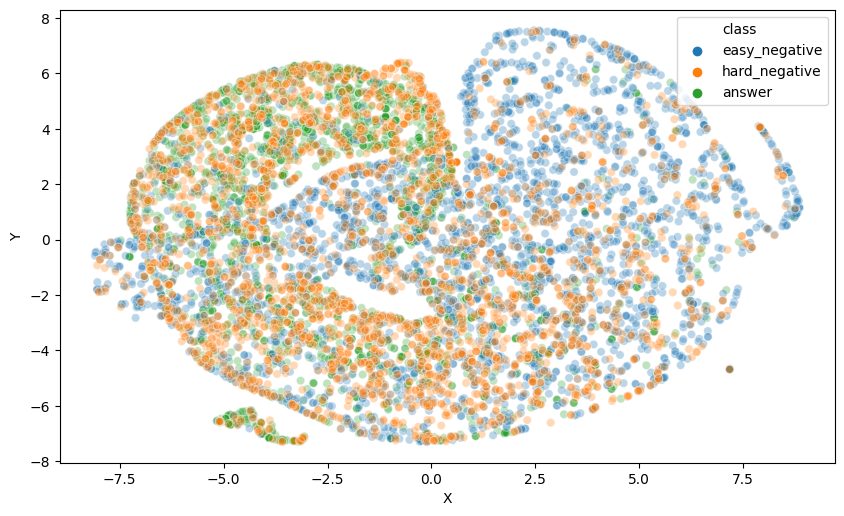

In [31]:
import seaborn as sns
plt.figure(figsize=(10, 6), dpi=100)
sns.scatterplot(x="X", y="Y",
              hue="class",
              legend='full',
              hue_order=['easy_negative','hard_negative','answer'],
              alpha=0.3,
              data=tsne_df2)

In [32]:
print('a')

a


[[57195  9075]
 [ 1514  3462]]


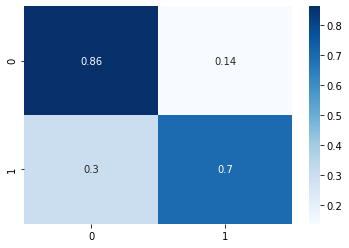

In [108]:
y_test = []
y_pred = []

x_test = [ x['representation'][0] for x in pairs_test ]
y_test = [ y['label'] for y in pairs_test ]

y_pred = sim_model.predict(np.array(x_test))
id_zeros = np.argwhere(y_pred >= 0.5)
id_ones = np.argwhere(y_pred < 0.5)
y_pred[id_zeros] = 0
y_pred[id_ones] = 1

from sklearn.metrics import confusion_matrix
import seaborn as sns

y_test = np.array(y_test).flatten()
y_pred = y_pred.flatten()

print(confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, cmap="Blues", annot=True)

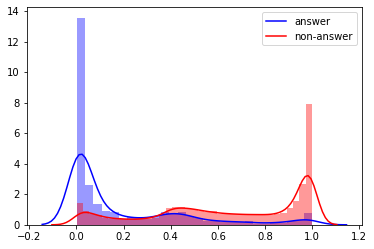

In [36]:
y_pred = sim_model.predict(np.array(x_test))
idx_1 = np.argwhere(y_test == 1)
idx_0 = np.argwhere(y_test == 0)
sns.distplot(y_pred[idx_1], kde_kws={'label':'answer'}, color='blue')
sns.distplot(y_pred[idx_0], kde_kws={'label':'non-answer'}, color='red')

In [33]:
sim_model.save( working_folder + "/sim_model_"+model_id+".h5" )

In [36]:
from tensorflow.keras.models import load_model
#sim_model.load_model(working_folder+"/sim_model_"+model_id+".h5")

## Test With BioASQ Data

In [37]:
cache = {}

In [38]:
from elasticsearch import Elasticsearch
import ranking
import importlib
importlib.reload(ranking)

bioasq_util.es = Elasticsearch(hosts=['168.176.36.10:9200'])
index_name = '2018_pubmed_baseline_title_abs_mesh'
doc_relative_url = 'http://www.ncbi.nlm.nih.gov/pubmed/'

def return_cache(q,a):
    global cache
    key = q[0:40]+a[0:40]
    if key not in cache:
        pair = { 'body':q, 'text':a, 'label':0 }
        data = transform_single_pair(pair)[0]
        cache[key] = data
    return cache[key]

def rank_text(q, a):
    try:
        #pair = qa_data.QAPair('_', q, '_', a, '_')
        pair = { 'body':q, 'text':a, 'label':0 }
        data = return_cache(q,a)
        #data = transform_single_pair(pair)[0]
        score = 1 - sim_model.predict_proba(np.expand_dims(data,axis=0))[0][0]
    except Exception as e:
        print('rank_text>>',e)
    return score

def rank_bioasq_passage(doc_id, question, passage, section):
    passage['beginSection'] = section
    passage['endSection'] = section
    passage['document'] = doc_relative_url + str(doc_id)
    passage['score'] = 0
    try:
        if (len(question)>5) & (len(passage['text'])>15):
            passage['score'] = rank_text(question, passage['text'])
    except Exception as e:
        print('rank_bioasq_passage>>',e)
        print(question)
        print(passage['text'])
        sys.exit('Error')
    return passage

def rank_document(question, doc_id, doc_title, doc_abstract):
    passages_ranked = []
    chunks_title = ranking.split_chunks(doc_title)
    title_passages_ranked = [ rank_bioasq_passage(doc_id, question, chunk, 'title') for chunk in chunks_title ]
    chunks_abstract = ranking.split_chunks(doc_abstract)
    abstract_passages_ranked = [ rank_bioasq_passage(doc_id, question, chunk, 'abstract') for chunk in chunks_abstract ]
    return title_passages_ranked + abstract_passages_ranked

def extract_rank_answer_candidates(question, docs):
    snippets = []
    w = np.linspace(0,0.0,len(docs))[::-1]
    count_pass1 = 0
    for i, doc in enumerate(docs):
        doc_id = doc.replace(doc_relative_url,'')
        doc_id, doc_title, doc_abstract = bioasq_util.get_doc(doc_id, index_name, remove_tags=True)
        #doc_id = doc[0].replace(doc_relative_url,'')
        #doc_title = doc[1]
        #doc_abstract = doc[2]
        snippets_ranked = rank_document(question, doc_id, doc_title, doc_abstract)
        count_pass1 += len(snippets_ranked)
        snippets_ranked = [ s for s in  snippets_ranked if s['score'] >= 0.6 ]
        for s in snippets_ranked:
            s['score'] = s['score'] + w[i]
        snippets.extend(snippets_ranked)
    #print('Percentage of remaining passages {}'.format(len(snippets)/count_pass1))
    return snippets

In [39]:
#evaluate over aueb documents
test_batch_docs = [ #('','8b5_ES_30_full.json')
                ('6B1_golden.json', eval_home+'/goolgle_best_docs/aueb_nlp-bioasq6b-submissions/1-aueb-nlp-5.json'),
                ('6B2_golden.json', eval_home+'/goolgle_best_docs/aueb_nlp-bioasq6b-submissions/2-aueb-nlp-5.json'),
                ('6B3_golden.json', eval_home+'/goolgle_best_docs/aueb_nlp-bioasq6b-submissions/3-aueb-nlp-5.json'),
                ('6B4_golden.json', eval_home+'/goolgle_best_docs/aueb_nlp-bioasq6b-submissions/4-aueb-nlp-5.json'),
                ('6B5_golden.json', eval_home+'/goolgle_best_docs/aueb_nlp-bioasq6b-submissions/5-aueb-nlp-5.json')
               ]
    
df = pd.DataFrame(columns=('batch', 'Mean precision', 'Recall', 'F-Measure', 'MAP', 'GMAP'))

for i, batch_file in enumerate(test_batch_docs):
    test_batch_json = json.load(open(batch_file[1]))
    for sample in tqdm(test_batch_json['questions'], position=0):
        snippets = extract_rank_answer_candidates(sample['body'], sample['documents'])
        snippets_sorted = sorted(snippets, key = lambda i: (i['score']), reverse=True)
        sample['snippets'] = snippets_sorted
        sample['documents'] = [ d[0] for d in sample['documents'] ][0:10]
        sample['documents'] = sample['documents'][0:10]
    submission = test_batch_json.copy()
    for q in submission['questions']:
        for s in q['snippets']:
            del s['score']
    submission_file_name =  working_folder + "/" + model_id + '_'+batch_file[1].split('/')[-1]
    json.dump(submission, open(submission_file_name, 'w'))
    docs_score, pass_score = bioasq_eval.get_scores_phaseA(batch_file[0], submission, path_home=eval_home)
    print('Document Scores',docs_score)
    print('Passage Scores',pass_score)
    df.loc[i] = [ batch_file[0].split('.')[0] + '_' + batch_file[1].split('/')[-1].split('.')[0] ] + pass_score

df.to_csv(working_folder + "/" + model_id+'.csv', index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Document Scores [0.0, 0.0, 0.0, 0.0, 1.0000000000000123e-05]
Passage Scores [0.036806382394148365, 0.22735099711095855, 0.05730877028169688, 0.054164346487307384, 0.0021198567332162315]


  2%|▏         | 2/100 [00:09<07:55,  4.86s/it]


KeyboardInterrupt: 

# Generate COVID DataSet

In [98]:
bert_ds_hard = []
bert_ds_easy = []
x_batch = []
x_pair = []

for i, pair in enumerate(pairs): 
    
    x_pred = np.array(pair['representation'][0])
    x_batch.append(x_pred)
    x_pair.append(pair)
    
    if ((i > 0) & (i % 1000 == 0)) | (i == len(pairs)-1):
        
        y_pred = sim_model.predict(np.array(x_batch))
        
        for j, score in enumerate(y_pred):
            file_tw = bert_ds_easy
            
            if score[0] < 0.5:
                file_tw = bert_ds_hard
                
            file_tw.append( {
                'id' : x_pair[j]['id'],
                'body' : x_pair[j]['body'],
                'text' : x_pair[j]['text'],
                'label' : x_pair[j]['label'],
                'params' : x_pair[j]['params'],
                'dml_dis_score' : float(score[0])
                }
            )
            
        x_pair = []
        x_batch = []

In [99]:
len(bert_ds_easy)

309544

In [ ]:
for x in bert_ds_easy

In [104]:
with open('dmlpr_dataset_hard.json', 'w') as jfile:
    json.dump(bert_ds_hard, jfile)